In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from modules import dataset, vqvae, tools

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Train the VQVAE model
Load the data from dataset.

In [2]:
data_train, data_validate, data_test = dataset.load_data()
print(len(data_train))
print(len(data_validate))
print(len(data_test))

9664
1120
544


Create image generator to pass to the vqvae model for training.

In [3]:
data_gen = dataset.data_generator(train_data = data_train, batch_size = 8)
validate_gen = dataset.validate_generator(validate_data = data_validate, batch_size = 8)

In [4]:
img= next(data_gen)
print(img.shape)
img = next(validate_gen)
print(img.shape)
print(len(data_train))
print(len(data_validate))

(8, 256, 256, 1)
(8, 256, 256, 1)
9664
1120


In [5]:
steps_per_epoch = len(data_train)/8
valiation_steps = len(data_validate)/8
print(steps_per_epoch)
print(valiation_steps)

1208.0
140.0


Train the VQVAE model.

In [6]:
vqvae_trainer = vqvae.VQVAE(latent_dim=256, num_embeddings=256)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
history = vqvae_trainer.fit(data_gen, epochs = 20, validation_data = validate_gen, batch_size = 8, 
                    validation_steps = valiation_steps, validation_batch_size = 8, steps_per_epoch = steps_per_epoch)

Epoch 1/20
1208/1208 [==============================] - 64s 52ms/step - total_loss: 0.0601 - reconstruction_loss: 0.0055 - vq_loss: 0.0546 - val_total_loss: 0.0052 - val_reconstruction_loss: 0.0022 - val_vq_loss: 0.0030
Epoch 2/20
1208/1208 [==============================] - 64s 53ms/step - total_loss: 0.0041 - reconstruction_loss: 0.0017 - vq_loss: 0.0024 - val_total_loss: 0.0037 - val_reconstruction_loss: 0.0016 - val_vq_loss: 0.0021
Epoch 3/20
1208/1208 [==============================] - 64s 53ms/step - total_loss: 0.0034 - reconstruction_loss: 0.0014 - vq_loss: 0.0020 - val_total_loss: 0.0033 - val_reconstruction_loss: 0.0014 - val_vq_loss: 0.0019
Epoch 4/20
1208/1208 [==============================] - 64s 53ms/step - total_loss: 0.0031 - reconstruction_loss: 0.0012 - vq_loss: 0.0019 - val_total_loss: 0.0031 - val_reconstruction_loss: 0.0012 - val_vq_loss: 0.0019
Epoch 5/20
1208/1208 [==============================] - 64s 53ms/step - total_loss: 0.0029 - reconstruction_loss: 0.0011

Plot some results of the model (original image vs. reconstructed image outputs from the model) 

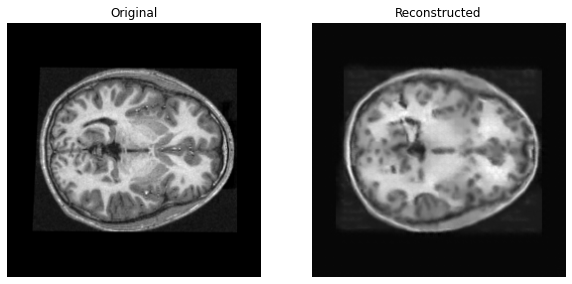

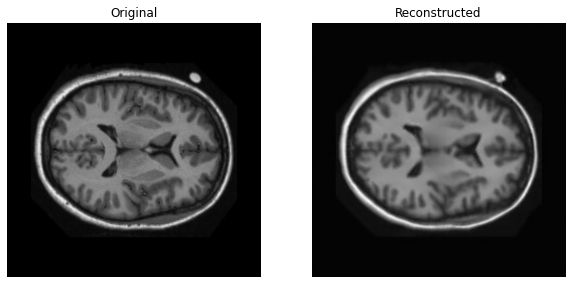

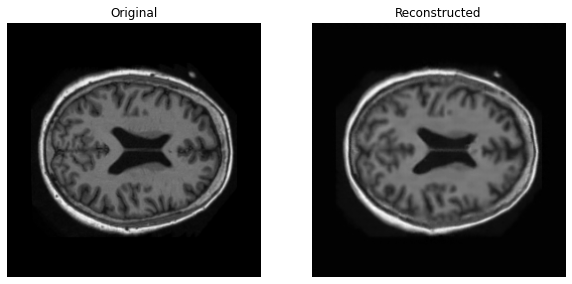

In [7]:
img_count = 3
tools.plot_images(img_count, data_test, vqvae_trainer)

Calculate the structured similarity between the original image and the reconstructed image.

In [8]:
print(tools.mean_ssim(data_test, vqvae_trainer))

0.9886118408557174


# Preprocess the data to be loaded into pixelcnn.
For each image, pass it to the trained vqvae encoder and map the output from the encoder to the closest latent embedding vector in the latent space. Since the dataset is large, it is impossible to load all the preprocessed image into the memory. Instead, I used a generator to load the images.

In [8]:
train_gen = dataset.train_codebook_generator(data_train, vqvae_trainer, batch_size = 32)

data = next(train_gen)
print(data[0].shape, data[1].shape)

(32, 32, 32, 256) (32, 32, 32, 256)


In [9]:
valid_gen = dataset.validate_codebook_generator(data_validate, vqvae_trainer, batch_size = 32)

data = next(valid_gen)
print(data[0].shape, data[1].shape)

(32, 32, 32, 256) (32, 32, 32, 256)
